In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.getcwd()

'/Users/mgorecki/Documents/projects/llm_fairness/folktexts'

In [3]:
import torch
import numpy
import os
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import json
from pathlib import Path
import matplotlib as mpl
import pandas as pd

import folktexts
from folktexts.llm_utils import get_model_size_B
#load the dataset
from folktexts.acs.acs_tasks import ACSTaskMetadata
from folktexts.acs.acs_dataset import ACSDataset

#baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from folktexts.evaluation import evaluate_predictions
from folktexts._io import load_json, save_json

plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

data_dir = Path("./data")

/Users/mgorecki/opt/miniconda3/envs/llm-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# LLMs to evaluate
LLM_MODELS = [
    # Google Gemma2 models
    "google/gemma-2b",
    "google/gemma-1.1-2b-it",
    "google/gemma-7b",
    "google/gemma-1.1-7b-it",
    "google/gemma-2-9b",
    "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "google/gemma-2-27b-it",
    # Meta Llama3 models
    "meta-llama/Meta-Llama-3-8B",
    "meta-llama/Meta-Llama-3-8B-Instruct",
    "meta-llama/Meta-Llama-3-70B",
    "meta-llama/Meta-Llama-3-70B-Instruct",
    # Mistral AI models
    "mistralai/Mistral-7B-v0.1",
    "mistralai/Mistral-7B-Instruct-v0.2",
    "mistralai/Mixtral-8x7B-v0.1",
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    "mistralai/Mixtral-8x22B-v0.1",
    "mistralai/Mixtral-8x22B-Instruct-v0.1",
    # Yi models
    "01-ai/Yi-34B",
    "01-ai/Yi-34B-Chat",
    # Qwen2 models
    # "Qwen/Qwen2-1.5B",
    # "Qwen/Qwen2-1.5B-Instruct",
    # "Qwen/Qwen2-7B",
    # "Qwen/Qwen2-7B-Instruct",
    # "Qwen/Qwen2-72B",
    # "Qwen/Qwen2-72B-Instruct",
]

In [5]:
numpy.random.randint(low=0,high=999, size=3)

array([225, 680, 953])

## ACS Tasks

In [6]:
# All ACS prediction tasks
ACS_TASKS = (
    "ACSIncome",
    "ACSEmployment",
    "ACSMobility",
    "ACSTravelTime",
    "ACSPublicCoverage",
)

In [7]:
# Load test data

# Fetch ACS task and dataset
task_name = ACS_TASKS[0]
acs_task = ACSTaskMetadata.get_task(task_name)
acs_dataset_configs = folktexts.benchmark.Benchmark.ACS_DATASET_CONFIGS.copy()
# acs_dataset = ACSDataset.make_from_task(
#     task=acs_task, cache_dir=data_dir, **acs_dataset_configs
# )
# X_test, y_test = acs_dataset.get_data_split("test")

In [8]:
descriptions_cols = {
    col: acs_task.cols_to_text[col].short_description for col in acs_task.features
}
descriptions_cols

{'AGEP': 'age',
 'COW': 'class of worker',
 'SCHL': 'highest educational attainment',
 'MAR': 'marital status',
 'OCCP': 'occupation',
 'POBP': 'place of birth',
 'RELP': 'relationship to the reference person in the survey',
 'WKHP': 'usual number of hours worked per week',
 'SEX': 'sex',
 'RAC1P': 'race'}

## Load LLM Predictions and Evaluation Results

In [9]:
RESULTS_ROOT_DIR = Path("./results/vary-seeds/")
seeds = [75, 183,457]

In [10]:
## Utility functions for data loading


def load_json(path: str | Path) -> object:
    """Loads a JSON file from disk and returns the deserialized object."""
    with open(path, "r") as f_in:
        return json.load(f_in)


def find_files(root_folder, pattern, dir_pattern=""):
    # Compile the regular expression pattern
    regex = re.compile(pattern)

    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(root_folder):
        #print("dirpath=", dirpath)
        if dir_pattern in dirpath:
            for filename in filenames:
                if regex.match(filename):
                    # If the filename matches the pattern, add it to the list
                    yield os.path.join(dirpath, filename)


def parse_model_name(name: str) -> str:
    name = name[name.find("--") + 2 :]
    return name


def get_base_name(name):
    name = name.replace("-Instruct", "")
    name = name.replace("-Chat", "")
    name = name.replace("-it", "")
    name = name.replace("-1.1", "")
    name = name.replace("-v0.2", "-v0.1")
    return name


model_col = "config_model_name"
# model_col = "model_name"
feature_subset_col = "config_feature_subset"
population_subset_col = "config_population_filter"
predictions_path_col = "predictions_path"

uses_all_features_col = "uses_all_features"
uses_all_samples_col = "uses_all_samples"


def parse_results_dict(dct) -> dict:
    """Parses results dict; brings all information to the top-level."""
    dct = dct.copy()
    dct.pop("plots", None)
    config = dct.pop("config", {})
    for key, val in config.items():
        dct[f"config_{key}"] = val

    # Parse model name
    dct[model_col] = parse_model_name(dct[model_col])
    dct[uses_all_features_col] = dct[feature_subset_col] is None
    if dct[feature_subset_col] is None:
        dct[feature_subset_col] = "full"

    dct[uses_all_samples_col] = dct[population_subset_col] is None

    dct["base_name"] = get_base_name(dct[model_col])
    dct["is_inst"] = dct["base_name"] != dct[model_col]

    assert not any(isinstance(val, dict) for val in dct.values()), dct
    return dct

In [11]:
results_llms = {} # format: results_llms[model_key][task_name][seed]
risk_scores_llms = {}

In [12]:
for model_key in LLM_MODELS:
    results_model = {}
    risk_scores_model = {}
    for task_name in ACS_TASKS:
        print(model_key, task_name)
        results_task = {}
        risk_scores_task = {}
        pattern_json = r"^results.bench-(?P<hash>\d+)[.]json$"
        pattern_csv = rf"{task_name}_full_seed-42_hash-(?P<hash>\d+)[.]test_predictions.csv"
        for file_path in find_files(RESULTS_ROOT_DIR, dir_pattern=f"{model_key.replace('/', '--')}_task-{task_name}", pattern=pattern_json):
            csv_file = [f for f in find_files(root_folder=Path(file_path).parent, pattern=pattern_csv)][0] #TODO: assuming there is exactly one file!!
            tmp = parse_results_dict(load_json(file_path))
            seed = tmp['config_seed']
            print(seed)
            results_task[seed] = tmp
            risk_scores_task[seed] = pd.read_csv(csv_file, index_col=0).drop("label", axis=1).rename(columns={"risk_score": model_key})
        results_model[task_name] = results_task
        risk_scores_model[task_name] = risk_scores_task
    results_llms[model_key] = results_model
    risk_scores_llms[model_key] = risk_scores_model


google/gemma-2b ACSIncome
75
457
183
google/gemma-2b ACSEmployment
457
75
183
google/gemma-2b ACSMobility
75
183
457
google/gemma-2b ACSTravelTime
183
75
google/gemma-2b ACSPublicCoverage
183
google/gemma-1.1-2b-it ACSIncome
183
457
75
google/gemma-1.1-2b-it ACSEmployment
457
75
183
google/gemma-1.1-2b-it ACSMobility
75
457
183
google/gemma-1.1-2b-it ACSTravelTime
183
457
75
google/gemma-1.1-2b-it ACSPublicCoverage
457
75
183
google/gemma-7b ACSIncome
75
457
183
google/gemma-7b ACSEmployment
457
75
183
google/gemma-7b ACSMobility
183
457
75
google/gemma-7b ACSTravelTime
457
183
75
google/gemma-7b ACSPublicCoverage
457
75
183
google/gemma-1.1-7b-it ACSIncome
183
75
457
google/gemma-1.1-7b-it ACSEmployment
183
457
75
google/gemma-1.1-7b-it ACSMobility
75
457
183
google/gemma-1.1-7b-it ACSTravelTime
457
75
183
google/gemma-1.1-7b-it ACSPublicCoverage
183
457
75
google/gemma-2-9b ACSIncome
75
457
183
google/gemma-2-9b ACSEmployment
75
457
183
google/gemma-2-9b ACSMobility
183
457
75
google

In [13]:
print("Models missing?\n")
for m in LLM_MODELS:
    if m not in list(results_llms.keys()):
        print(f"{m} missing completely")
    else:
        for t in ACS_TASKS:
            try:
                results_llms[m][t]
                for s in seeds:
                    try:
                        results_llms[m][t][s]
                    except KeyError: print(f"{m} {t} {s} missing")
            except KeyError: print(f"{m} {t} missing task completey")

Models missing?

google/gemma-2b ACSTravelTime 457 missing
google/gemma-2b ACSPublicCoverage 75 missing
google/gemma-2b ACSPublicCoverage 457 missing
google/gemma-2-27b-it ACSMobility 457 missing
google/gemma-2-27b-it ACSTravelTime 457 missing
meta-llama/Meta-Llama-3-70B ACSMobility 183 missing
meta-llama/Meta-Llama-3-70B ACSTravelTime 75 missing
meta-llama/Meta-Llama-3-70B-Instruct ACSIncome 183 missing
meta-llama/Meta-Llama-3-70B-Instruct ACSMobility 183 missing
meta-llama/Meta-Llama-3-70B-Instruct ACSTravelTime 183 missing
meta-llama/Meta-Llama-3-70B-Instruct ACSPublicCoverage 183 missing


In [14]:
risk_scores_all_tasks = {}
for task_name in ACS_TASKS:
    for seed in seeds:
        risk_scores_all_tasks[task_name] = {}
        risk_scores_per_seed = []
        try: 
            for model_key in LLM_MODELS:
                risk_scores_per_seed.append(risk_scores_llms[model_key][task_name][seed])
            risk_scores_per_seed = pd.concat(risk_scores_per_seed, axis=1)
            risk_scores_all_tasks[task_name][seed] = risk_scores_per_seed
        except: 
            risk_scores_all_tasks[task_name][seed] = None
            print(f"skipped {task_name} seed {seed}")

skipped ACSIncome seed 183
skipped ACSMobility seed 183
skipped ACSMobility seed 457
skipped ACSTravelTime seed 75
skipped ACSTravelTime seed 183
skipped ACSTravelTime seed 457
skipped ACSPublicCoverage seed 75
skipped ACSPublicCoverage seed 183
skipped ACSPublicCoverage seed 457


## Baseline Models

In [15]:
baselines = {
    "Constant": DummyClassifier(strategy='prior'),
    "LR": LogisticRegression(),
    "GBM": HistGradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
}

In [16]:
def fit_and_eval(
    clf: LogisticRegression | HistGradientBoostingClassifier | XGBClassifier | DummyClassifier,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    s_test: torch.Tensor,
    fillna: bool = False,
) -> dict:
    """Fit and evaluate a given classifier on the given data."""
    assert len(X_train) == len(y_train) and len(X_test) == len(y_test) == len(s_test)

    train_nan_count = X_train.isna().any(axis=1).sum()
    if fillna and train_nan_count > 0:
        print(f"Found {train_nan_count} NaN values, fill with -1.")
        # Fill NaNs with value=-1
        X_train = X_train.fillna(axis="columns", value=-1)
        X_test = X_test.fillna(axis="columns", value=-1)

    # Fit on train data
    clf.fit(X_train, y_train)

    # Evaluate on test data
    y_test_scores = clf.predict_proba(X_test)[:, -1]
    clf_prediction_eval = evaluate_predictions(
        y_true=y_test.to_numpy(),
        y_pred_scores=y_test_scores,
        sensitive_attribute=s_test,
        threshold=0.5,
    )

    return y_test_scores, clf_prediction_eval

def add_meta_data(results: dict, task: str, clf_name: str):
    updated_results = results.copy()
    updated_results["config_task_name"] = task
    updated_results["config_model_name"] = clf_name
    updated_results["name"] = clf_name
    updated_results["num_features"] = -1
    updated_results["uses_all_features"] = True
    
    return updated_results

In [17]:
BASELINE_RESULTS_PATH =  Path("./results/eval-fairness/baseline-results/")

In [18]:
all([True, True])

True

In [19]:
def run_baselines(tasks: list, rerun: bool=False):
    baseline_results_all_tasks = {}
    baseline_risk_scores_all_tasks = {}
    for task_name in tasks:
        print(task_name)

        if all([(BASELINE_RESULTS_PATH / f"{clf_name}_task-{task_name}").exists() for clf_name, clf in baselines.items()]) and not rerun: 
                print("All classfiers avalaibe for this task, skip loading data set.")
        else:
        
            dataset = ACSDataset.make_from_task(
                task_name, cache_dir=data_dir, **acs_dataset_configs
            )

            X_train, y_train = dataset.get_train()
            X_test, y_test = dataset.get_test()
            s_test = None
            if dataset.task.sensitive_attribute is not None:
                s_test = dataset.get_sensitive_attribute_data().loc[y_test.index]

        print("Run baselines")
        results = {}
        risk_scores = []
        for clf_name, clf in baselines.items():
            clf_path = BASELINE_RESULTS_PATH / f"{clf_name}_task-{task_name}"
            if (clf_path).exists() and not rerun:
                print("Load predictions from file.")
                scores = pd.read_csv(clf_path / f'{task_name}.test_predictions.csv')
                prediction_eval = load_json(path=clf_path / f'{task_name}-results.bench.json')
            else: 
                scores, prediction_eval = fit_and_eval(
                    clf, X_train, y_train, X_test, y_test, s_test, fillna=(clf_name == "LR")
                )
                scores = pd.Series(scores, index=y_test.index, name=f"{clf_name}_task-{task_name}")
                prediction_eval = add_meta_data(prediction_eval, task=task_name, clf_name=clf_name)

                print(f"Save predictions at '{clf_path}'.")
                clf_path.mkdir(parents=True, exist_ok=True)
                scores.to_csv( clf_path / f'{task_name}.test_predictions.csv')
                save_json(obj=prediction_eval, path=clf_path / f'{task_name}-results.bench.json')
                
            results[clf_name] = prediction_eval
            risk_scores.append(scores)

        baseline_results_all_tasks[task_name] = results
        baseline_risk_scores_all_tasks[task_name] = pd.concat(risk_scores, axis=1)

    return baseline_risk_scores_all_tasks, baseline_results_all_tasks

In [20]:
baseline_results = run_baselines(tasks=ACS_TASKS)

ACSIncome
All classfiers avalaibe for this task, skip loading data set.
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
ACSEmployment
All classfiers avalaibe for this task, skip loading data set.
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
ACSMobility
All classfiers avalaibe for this task, skip loading data set.
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
ACSTravelTime
All classfiers avalaibe for this task, skip loading data set.
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions from file.
ACSPublicCoverage
All classfiers avalaibe for this task, skip loading data set.
Run baselines
Load predictions from file.
Load predictions from file.
Load predictions from file.
Load predictions fro

In [21]:
baseline_risk_scores_all_tasks, baseline_results_all_tasks = baseline_results

## Evaluate Results

In [22]:
model_colors = {
    "gemma": "tab:blue",
    "Meta": "tab:olive",
    "Mistral": "tab:orange",
    "Yi": "tab:green",
    "Mixtral": "tab:red",
}

def prettify_model_name(name: str) -> str:
    """Get prettified version of the given model name."""
    dct = {
        "meta-llama/Meta-Llama-3-70B": "Llama 3 70B",
        "meta-llama/Meta-Llama-3-70B-Instruct": "Llama 3 70B (it)",
        "meta-llama/Meta-Llama-3-8B": "Llama 3 8B",
        "meta-llama/Meta-Llama-3-8B-Instruct": "Llama 3 8B (it)",
        "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B (it)",
        "mistralai/Mistral-7B-v0.1": "Mistral 7B",
        "mistralai/Mixtral-8x22B-Instruct-v0.1": "Mixtral 8x22B (it)",
        "mistralai/Mixtral-8x22B-v0.1": "Mixtral 8x22B",
        "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B (it)",
        "mistralai/Mixtral-8x7B-v0.1": "Mixtral 8x7B",
        "01-ai/Yi-34B": "Yi 34B",
        "01-ai/Yi-34B-Chat": "Yi 34B (chat)",
        "google/gemma-1.1-2b-it": "Gemma 2B (it)",
        "google/gemma-1.1-7b-it": "Gemma 7B (it)",
        "google/gemma-2b": "Gemma 2B",
        "google/gemma-7b": "Gemma 7B",
        "google/gemma-2-9b": "Gemma 2 9B",
        "google/gemma-2-9b-it": "Gemma 2 9B (it)",
        "google/gemma-2-27b": "Gemma 2 27B",
        "google/gemma-2-27b-it": "Gemma 2 27B (it)",
    }

    if name in dct:
        return dct[name]
    else:
        print(f"Couldn't find prettified name for {name}.")
        return name

In [ ]:
results_llms

In [25]:
finished_models = [
    m
    for m in LLM_MODELS
    if m in list(results_llms.keys())
]
finished_models.sort(key=get_model_size_B)
finished_models

['google/gemma-2b',
 'google/gemma-1.1-2b-it',
 'google/gemma-7b',
 'google/gemma-1.1-7b-it',
 'mistralai/Mistral-7B-v0.1',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'meta-llama/Meta-Llama-3-8B',
 'meta-llama/Meta-Llama-3-8B-Instruct',
 'google/gemma-2-9b',
 'google/gemma-2-9b-it',
 'google/gemma-2-27b',
 'google/gemma-2-27b-it',
 '01-ai/Yi-34B',
 '01-ai/Yi-34B-Chat',
 'mistralai/Mixtral-8x7B-v0.1',
 'mistralai/Mixtral-8x7B-Instruct-v0.1',
 'meta-llama/Meta-Llama-3-70B',
 'meta-llama/Meta-Llama-3-70B-Instruct',
 'mistralai/Mixtral-8x22B-v0.1',
 'mistralai/Mixtral-8x22B-Instruct-v0.1']

In [33]:
model_name_only = lambda m: m.split("/")[1] if "/" in m else m
model_to_key = lambda m, t: m.replace("/", "--") + f"_task-{t}"


def get_models_for_task(task: str) -> list:
    """Get a list of models for which results are available. 

    Args:
        task (str): task name, one of ACS_TASKS

    Returns:
        list: list of model names
    """
    models = [
        m
        for m in LLM_MODELS
        if m in list(results_llms.keys()) ## TODO: not incorporating the task currently
    ]
    models.sort(key=get_model_size_B)
    return models


def is_instruction_tuned(model_name: str) -> bool:
    """ Indicator if a model is instruction tuned (solely inferred from the model name).

    Args:
        model_name (str): name of the model

    Returns:
        bool: model is instruction-finetuned
    """
    indicators = ["Instruct", "it", "Chat"]
    return any(ind in model_name for ind in indicators)

In [29]:
colors = cm.rainbow(numpy.linspace(0, 1, len(baselines.keys())+1))[1:]
baseline_colors = {list(baselines.keys())[i]: colors[i] for i in range(len(baselines.keys()))}


In [52]:
def scatter_plot(task, metric, upper_lim=1.01):
    models = get_models_for_task(task)
    models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
    models_instruct = [m for m in models if is_instruction_tuned(m)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(task, fontsize=14)

    axs[0].set_title("Non-Instruction-Tuned")
    axs[0].set_xlabel("models")
    axs[0].set_ylim(0, upper_lim)
    axs[0].set_ylabel(metric)
    axs[0].set_xticks(
        torch.arange(0, len(models_non_instruct)),
        list(map(prettify_model_name, models_non_instruct)),
        rotation=45,
        ha="right",
    )

    axs[1].set_title("Instruction-Tuned")
    axs[1].set_xlabel("models")
    axs[1].set_ylim(0, upper_lim)
    axs[1].set_ylabel(metric)
    axs[1].set_xticks(
        torch.arange(0, len(models_instruct)),
        list(map(prettify_model_name, models_instruct)),
        rotation=45,
        ha="right",
    )

    offset = 0.4
    for i, modelset in enumerate([models_non_instruct, models_instruct]):
        for baseline_name, baseline_res in baseline_results_all_tasks[task].items(): 
            if baseline_name in ["Constant", "GBM"]:
                axs[i].hlines(baseline_res[metric], xmin=-offset, xmax=len(modelset)-(1-offset), colors=baseline_colors[baseline_name], label=baseline_name, linestyle='-', zorder=0)

    
    for m in models:
        for seed in seeds:
            idx = (
                models_non_instruct.index(m)
                if not is_instruction_tuned(m)
                else models_instruct.index(m)
            )
            try:
                axs[int(is_instruction_tuned(m))].scatter(
                    idx,
                    results_llms[m][task][seed][metric],
                    edgecolor=model_colors[m.split("/")[1].split("-")[0]],
                    marker = 'o', #'o', 
                    facecolors='none',
                    s=60,
                )
            except KeyError:
                print(f"skipped seed {seed}")
                pass

    legend_items = axs[0].get_legend_handles_labels()
    handles = legend_items[0]#+ legend_costs[0]
    labels = legend_items[1] #+ legend_costs[1]

    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1.0), handlelength=0.95, handletextpad=0.5)
    plt.show()


def bar_plot(task, metric, bar_width=0.25):
    models = get_models_for_task(task)
    models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
    models_instruct = [m for m in models if is_instruction_tuned(m)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(task, fontsize=14)

    axs[0].set_title("Non-Instruction-Tuned")
    axs[0].set_xlabel("models")
    axs[0].set_ylim(0, 1.01)
    axs[0].set_ylabel(metric)
    axs[0].set_xticks(
        torch.arange(0, len(models_non_instruct)),
        list(map(model_name_only, models_non_instruct)),
        rotation=45,
        ha="right",
    )

    axs[1].set_title("Instruction-Tuned")
    axs[1].set_xlabel("models")
    axs[1].set_ylim(0, 1.01)
    axs[1].set_ylabel(metric)
    axs[1].set_xticks(
        torch.arange(0, len(models_instruct)),
        list(map(model_name_only, models_instruct)),
        rotation=45,
        ha="right",
    )

    offset = 0.4
    for i, modelset in enumerate([models_non_instruct, models_instruct]):
        for baseline_name, baseline_res in baseline_results_all_tasks[task].items(): 
            axs[i].hlines(baseline_res[metric], xmin=-offset, xmax=len(modelset)-(1-offset), colors=baseline_colors[baseline_name], label=baseline_name)


    for m in models:
        idx = (
            models_non_instruct.index(m)
            if not is_instruction_tuned(m)
            else models_instruct.index(m)
        )
        axs[int(is_instruction_tuned(m))].bar(
            idx,
            results_all_tasks[task][model_to_key(m, task)][metric],
            width=bar_width,
            color=model_colors[m.split("/")[1].split("-")[0]],
        )

    plt.show()

In [53]:
# Print Task Info
#  for task_name in ACS_TASKS:
#     print("\n", task_name)
#     acs_task = ACSTaskMetadata.get_task(task_name)
#     descriptions_cols = {
#         col: acs_task.cols_to_text[col].short_description for col in acs_task.features
#     }
#     print("Features", acs_task.features)
#     print(descriptions_cols)
#     print("Sensitive Attribute", acs_task.sensitive_attribute)
#     print("Target", acs_task.get_target())

## Non-Instruction-Tuned Models vs. Instruction-Tuned Mondels

### Overall Accuracy

skipped seed 183


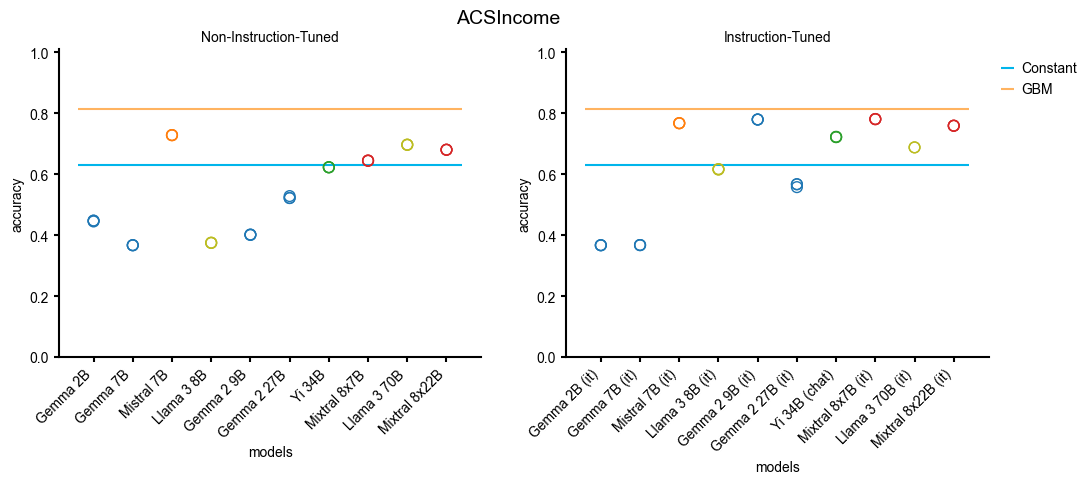

Constant : 0.6321
LR : 0.7429
GBM : 0.8132
XGBoost : 0.8173


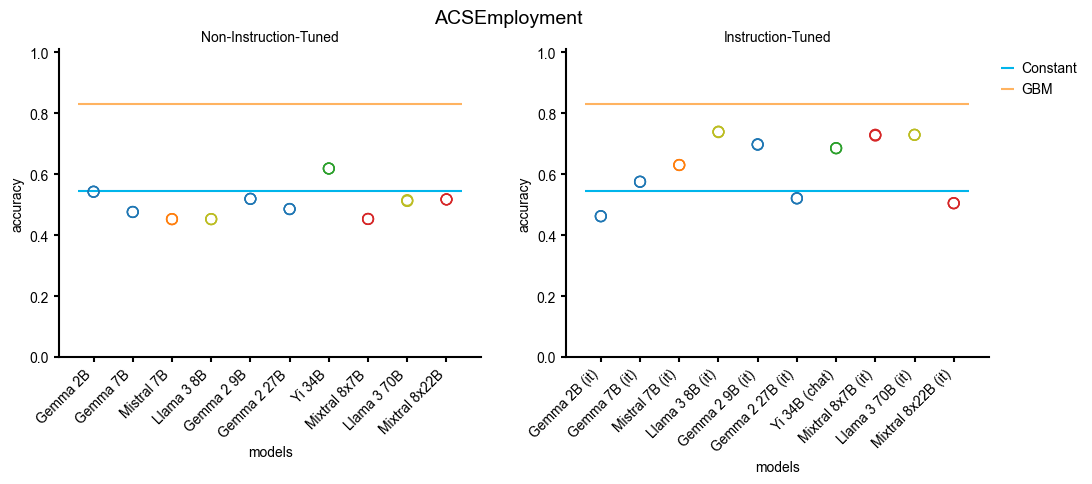

Constant : 0.5466
LR : 0.7835
GBM : 0.8311
XGBoost : 0.8316
skipped seed 457
skipped seed 183
skipped seed 183


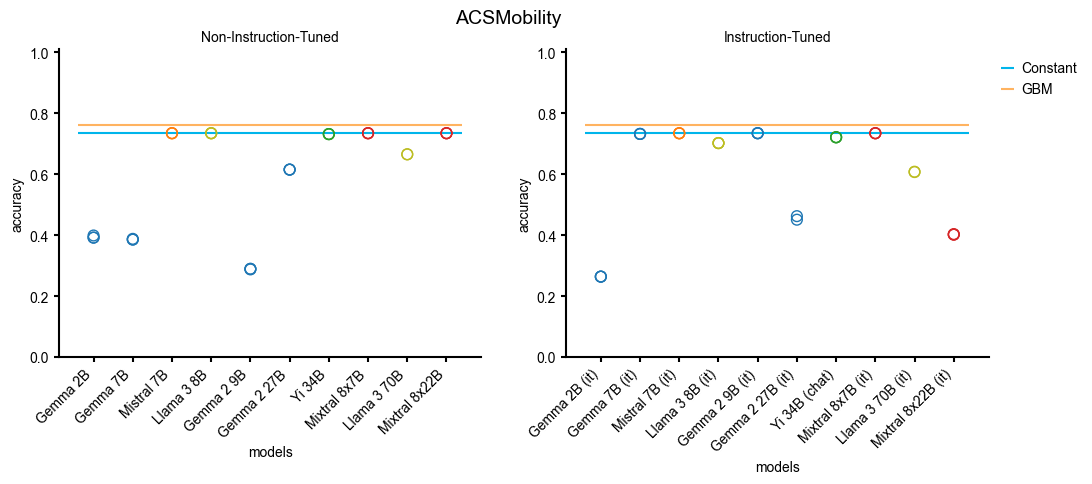

Constant : 0.7351
LR : 0.7356
GBM : 0.7630
XGBoost : 0.7643
skipped seed 457
skipped seed 457
skipped seed 75
skipped seed 183


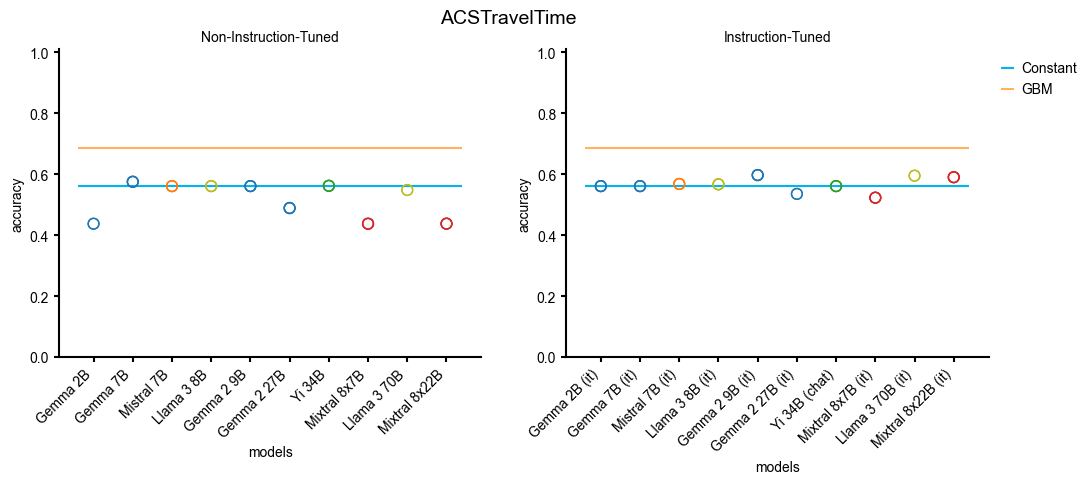

Constant : 0.5617
LR : 0.5563
GBM : 0.6874
XGBoost : 0.7030
skipped seed 75
skipped seed 457
skipped seed 183


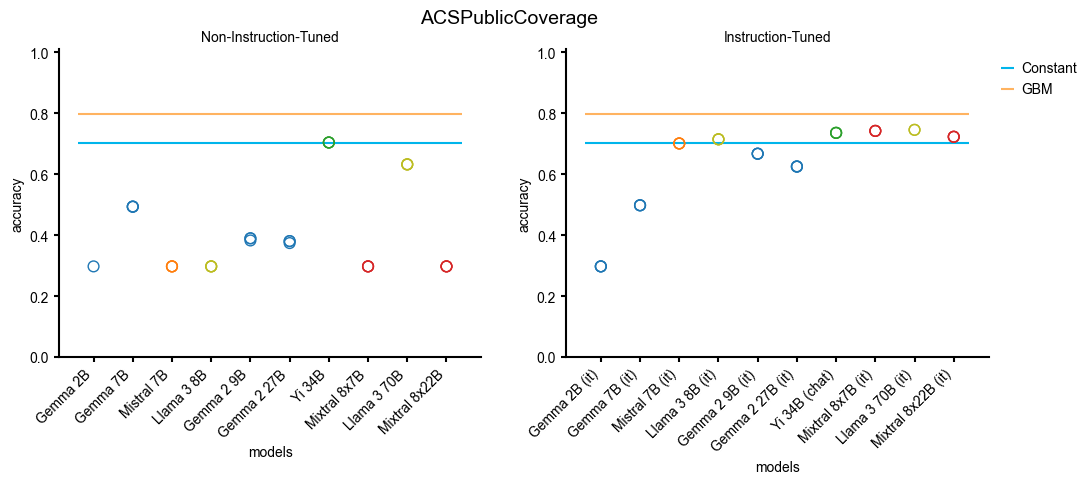

Constant : 0.7016
LR : 0.7263
GBM : 0.7981
XGBoost : 0.8016


In [54]:
metric = 'accuracy'
for task in ACS_TASKS:
    scatter_plot(task, metric= metric)
    for baseline_name, baseline_res in baseline_results_all_tasks[task].items(): 
        print(f"{baseline_name} : {baseline_res[metric]:.4f}")

### Fairness Violations

#### FNR

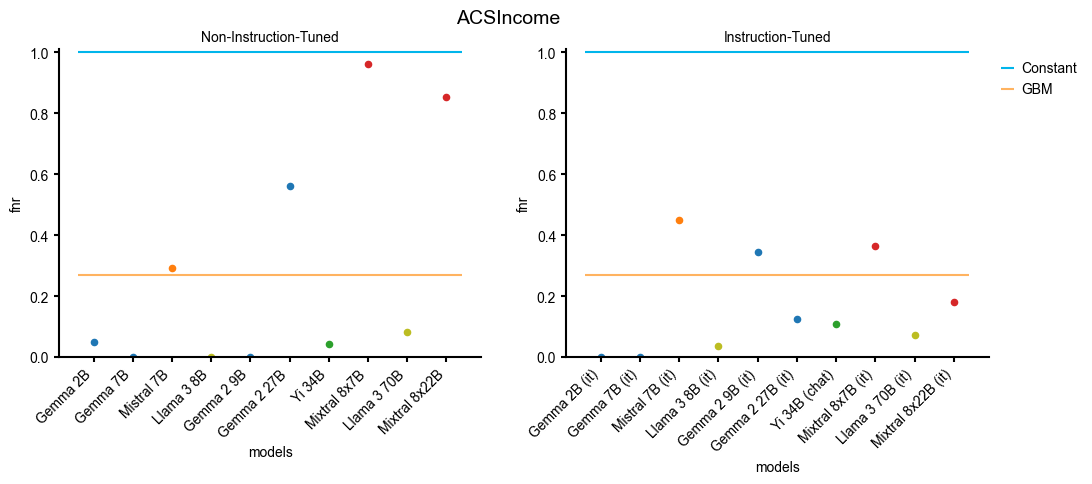

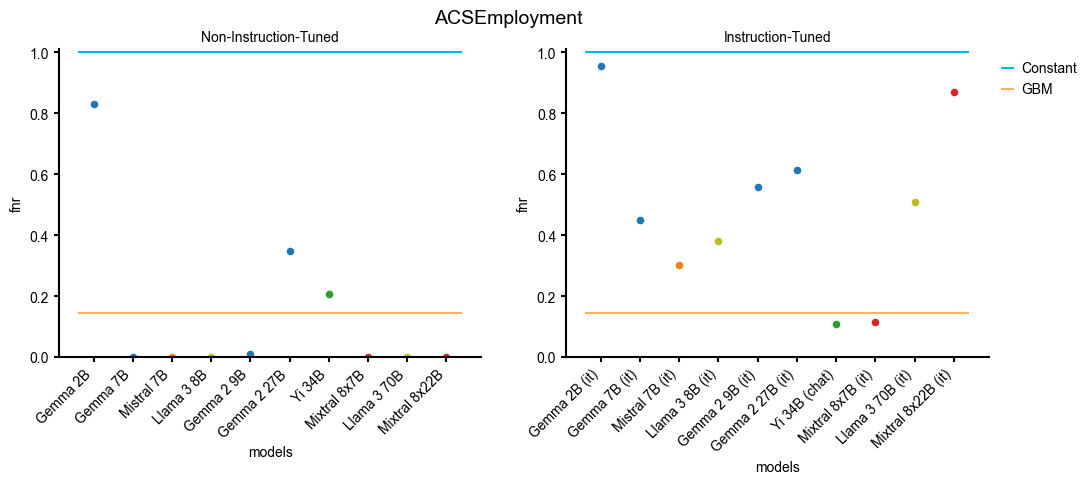

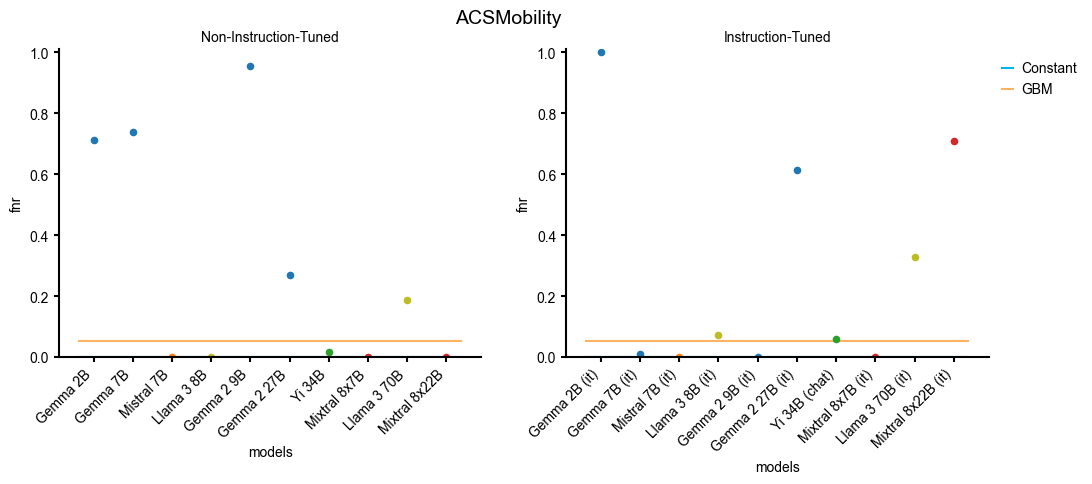

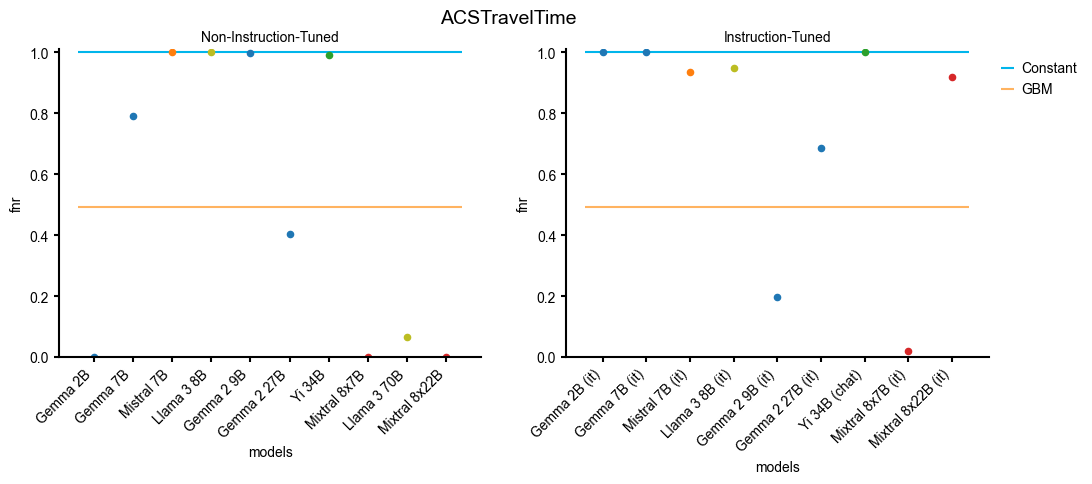

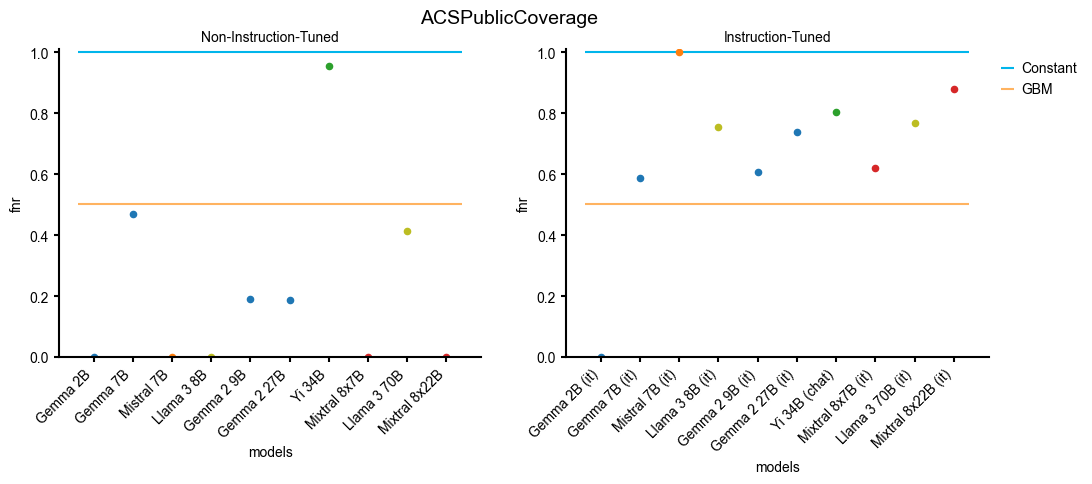

In [27]:
for task in ACS_TASKS:
    scatter_plot(task, metric="fnr")  # 1-tpr

#### Max difference in FNR

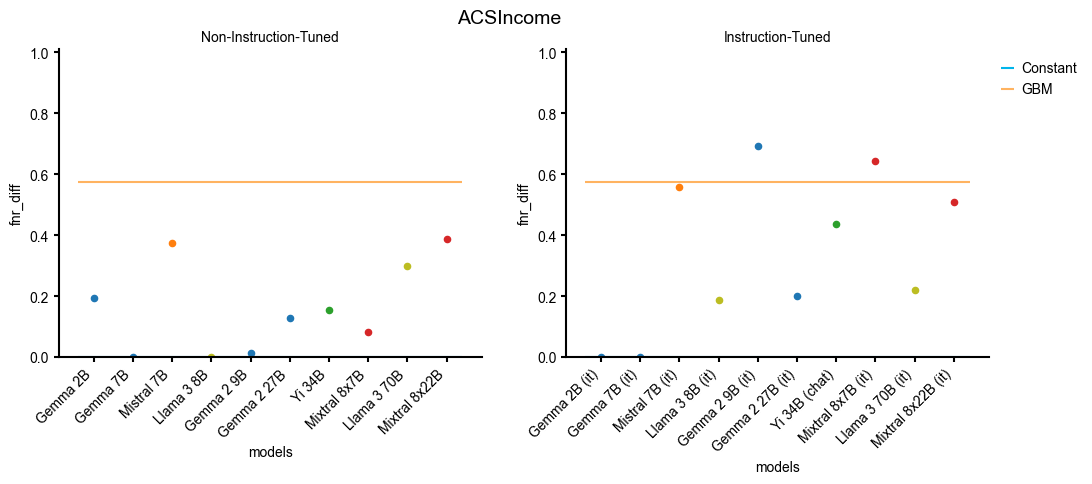

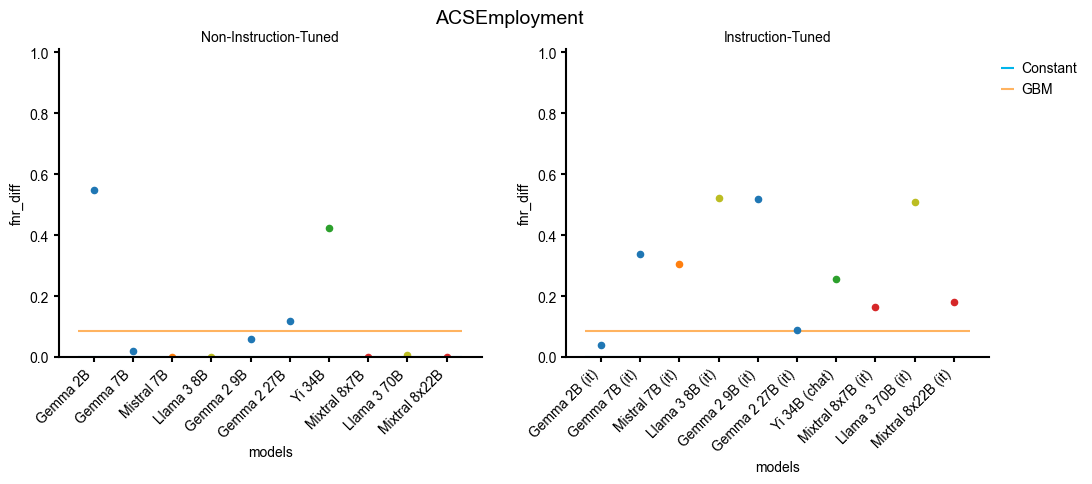

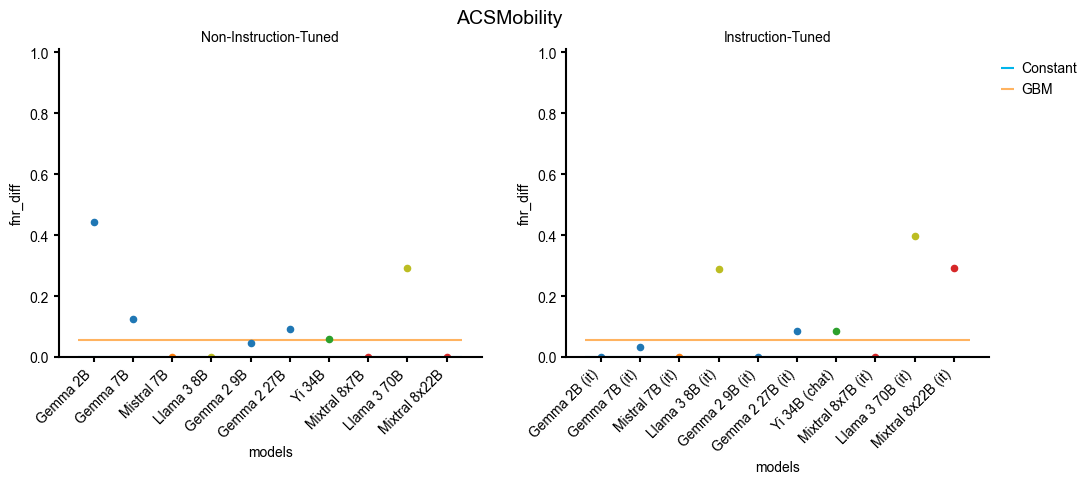

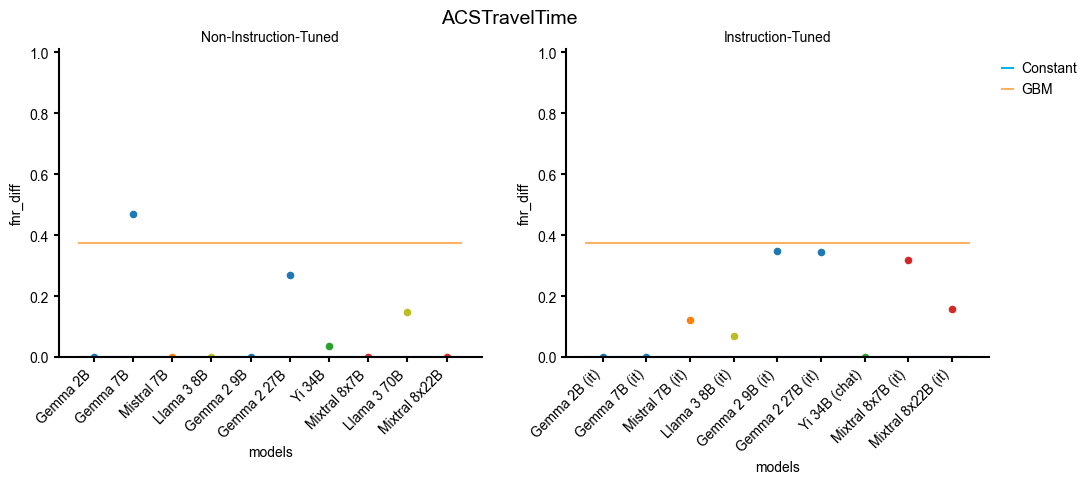

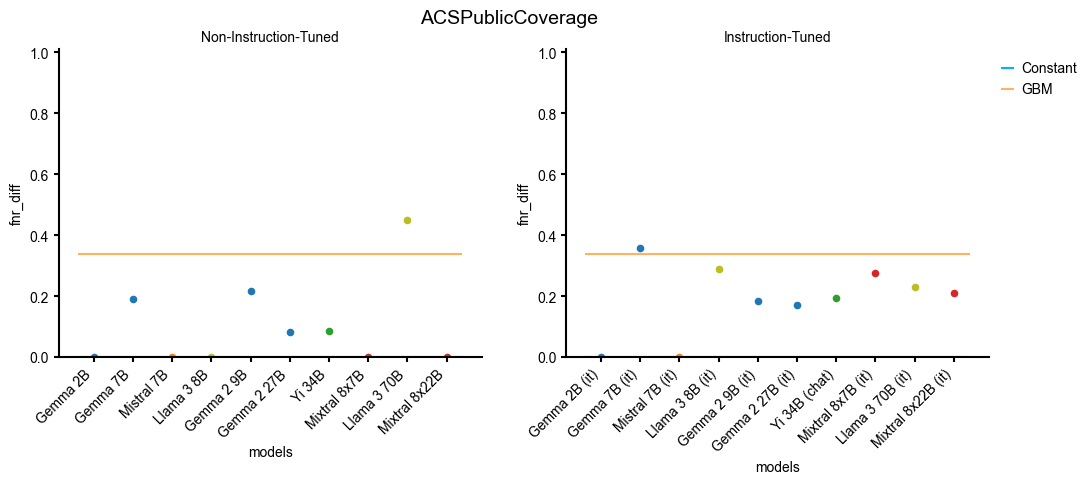

In [28]:
for task in ACS_TASKS:
    scatter_plot(task, metric="fnr_diff")  # 1-tpr

#### FPR

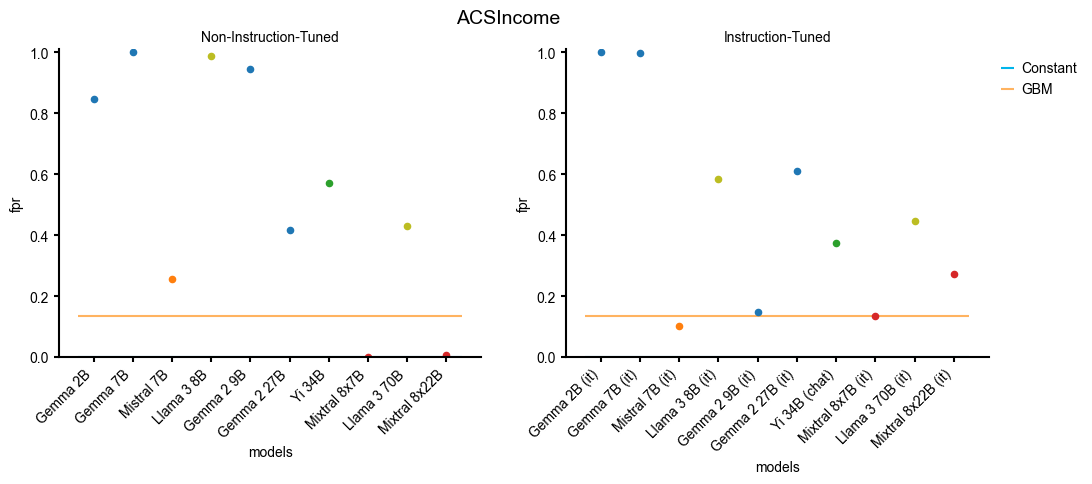

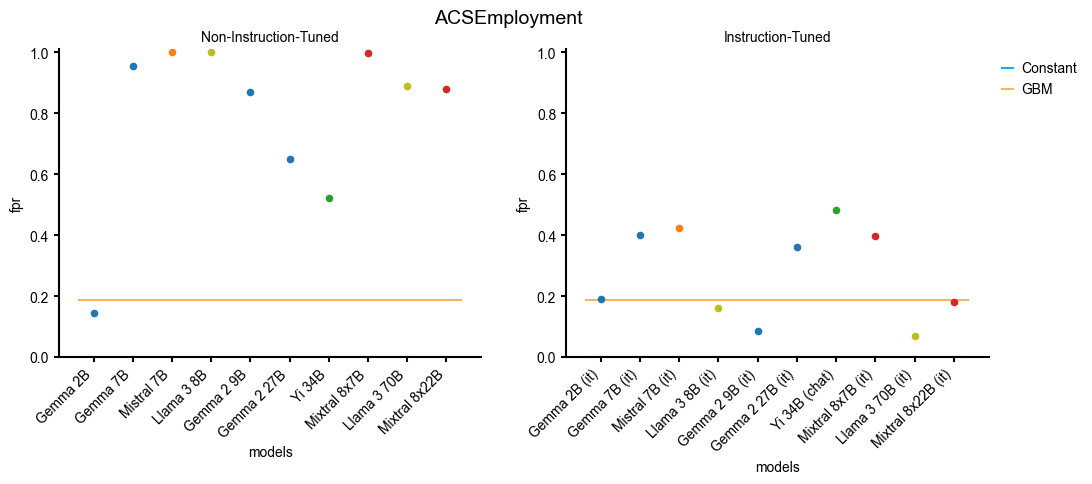

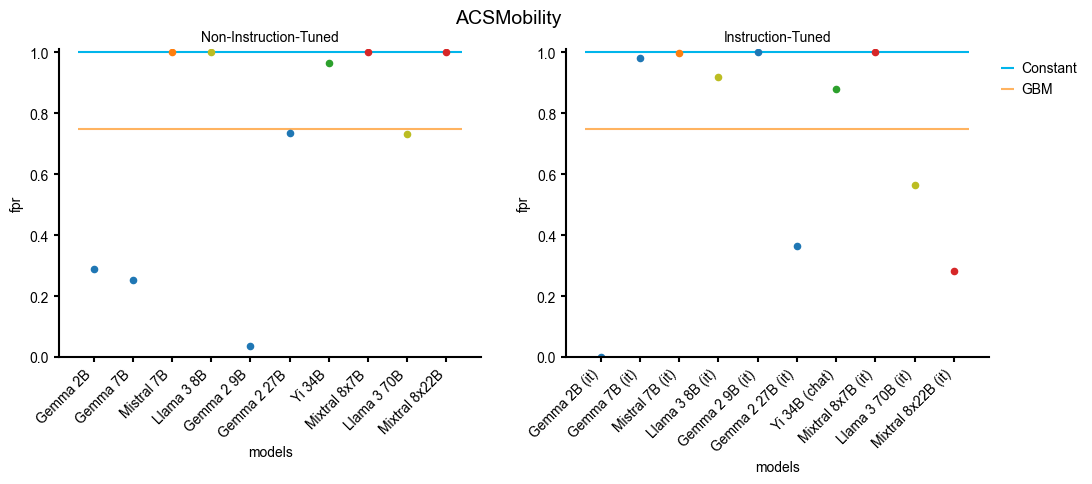

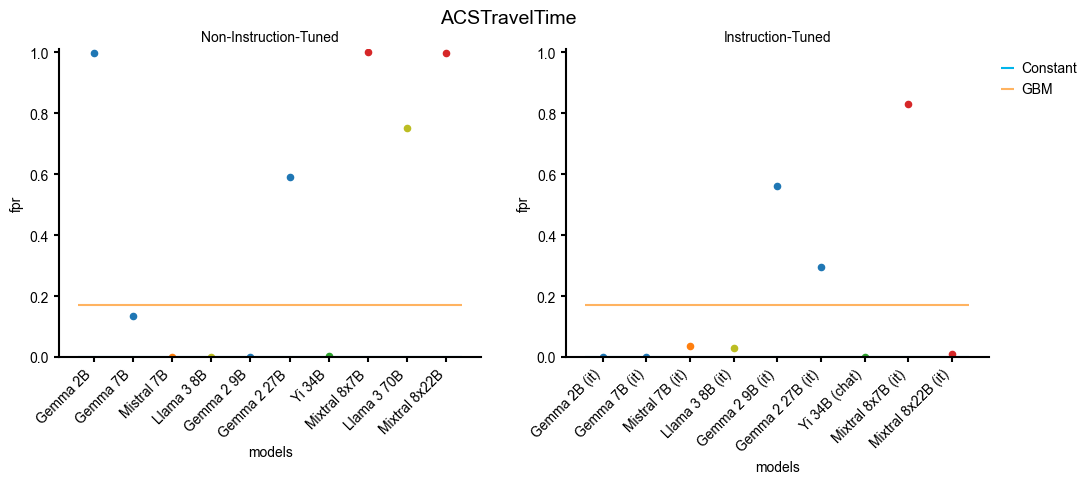

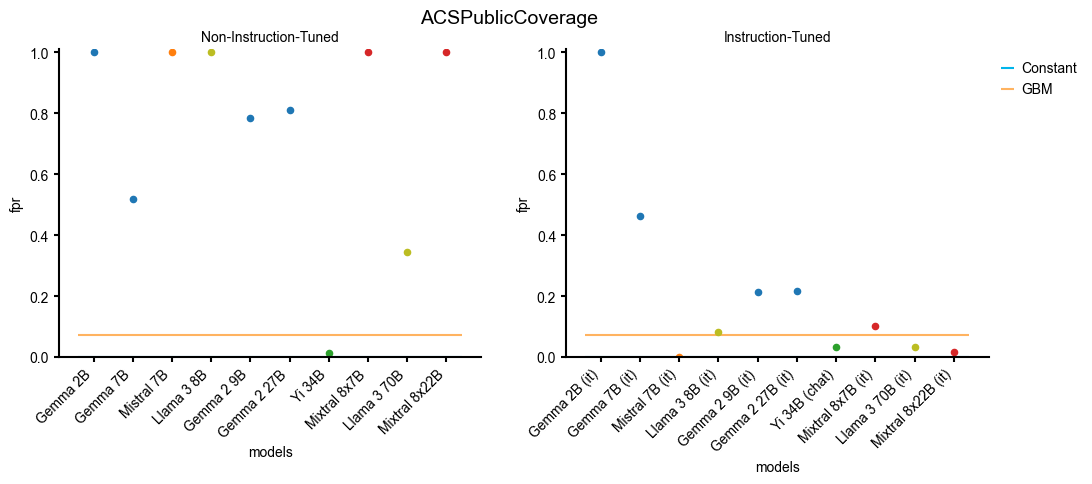

In [29]:
for task in ACS_TASKS:
    scatter_plot(task, metric="fpr")  # 1-tnr

#### Max difference in FPR

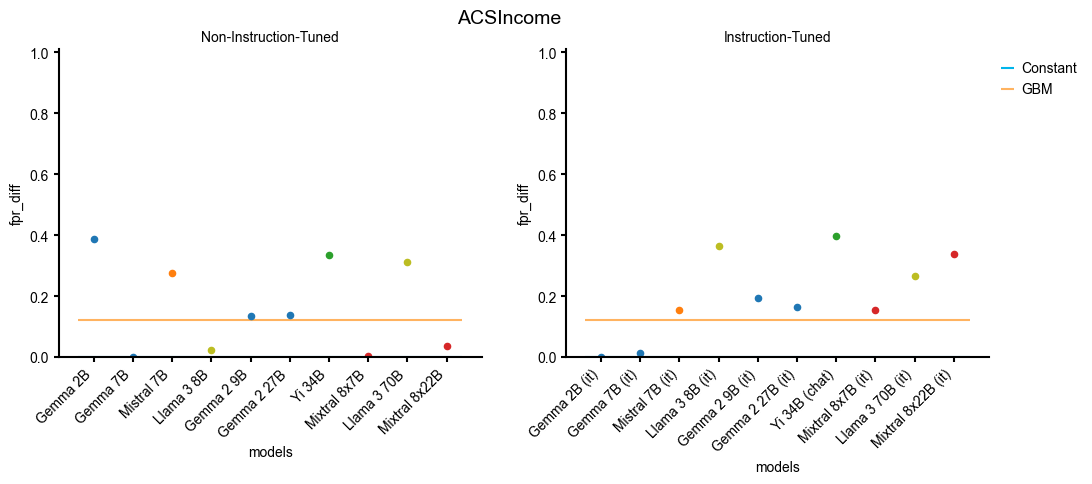

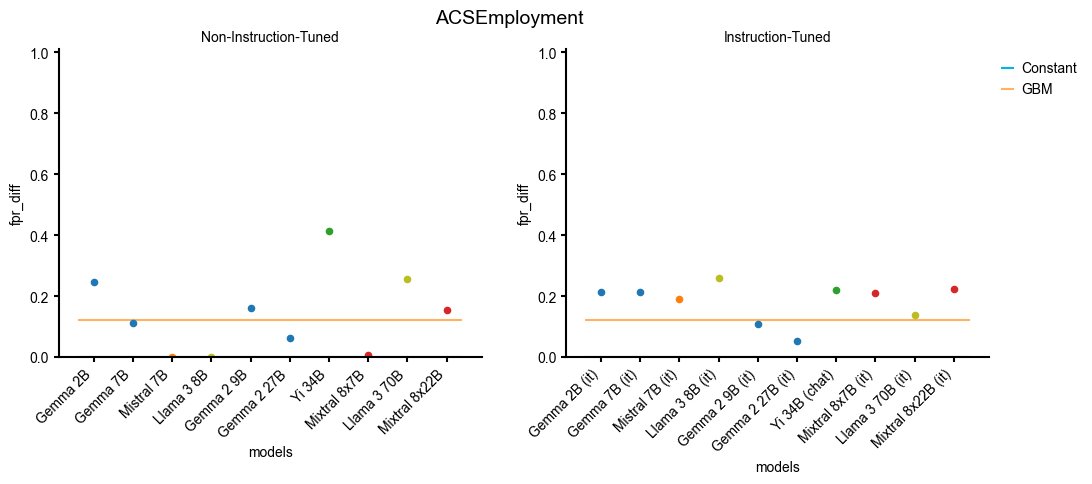

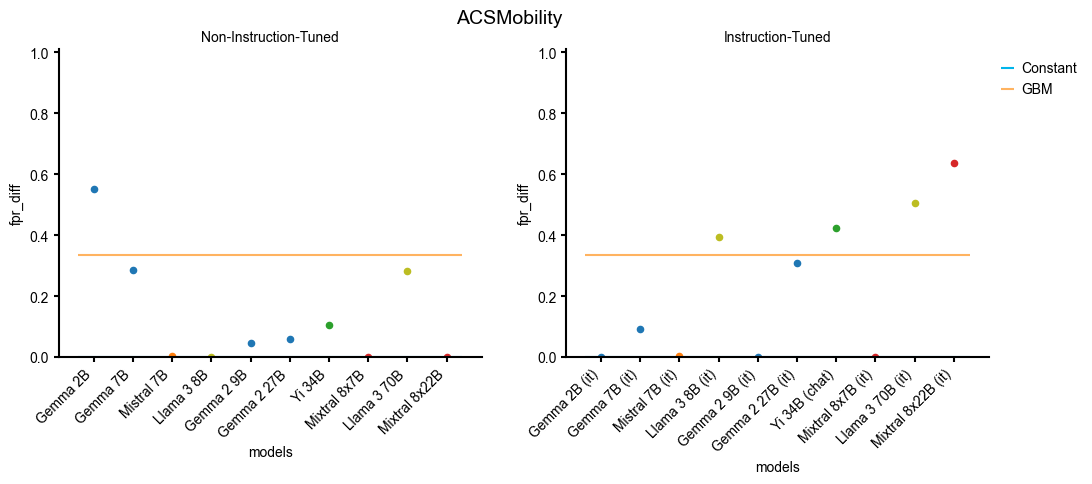

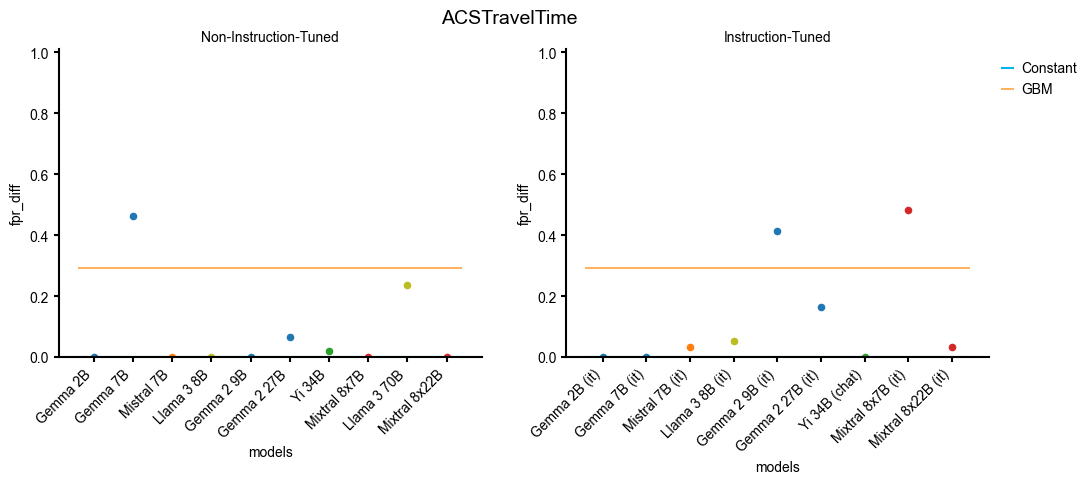

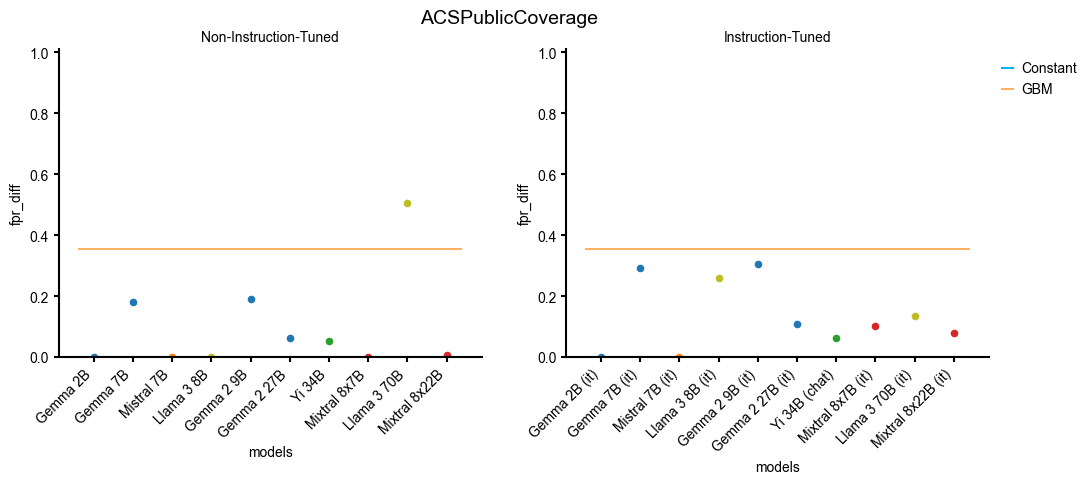

In [30]:
for task in ACS_TASKS:
    scatter_plot(task, metric="fpr_diff")

#### PPR

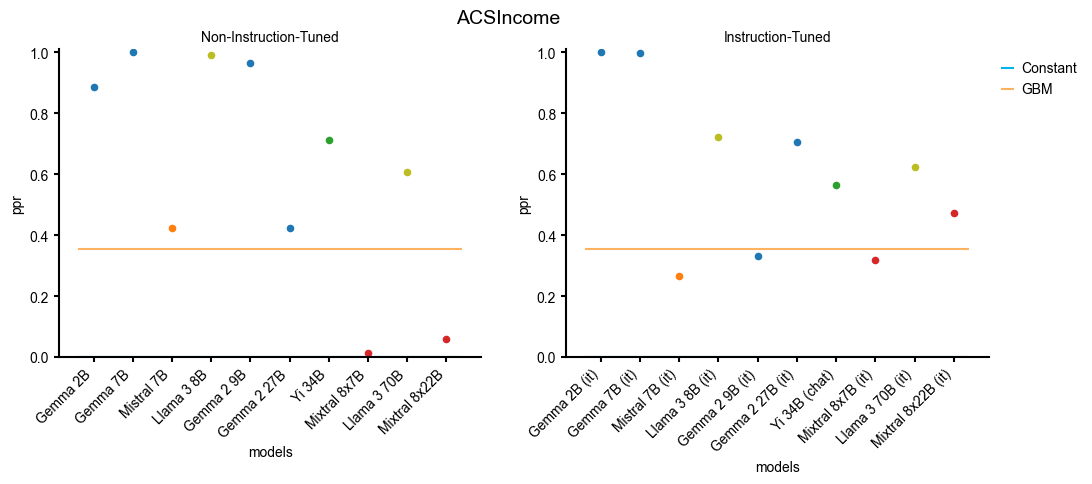

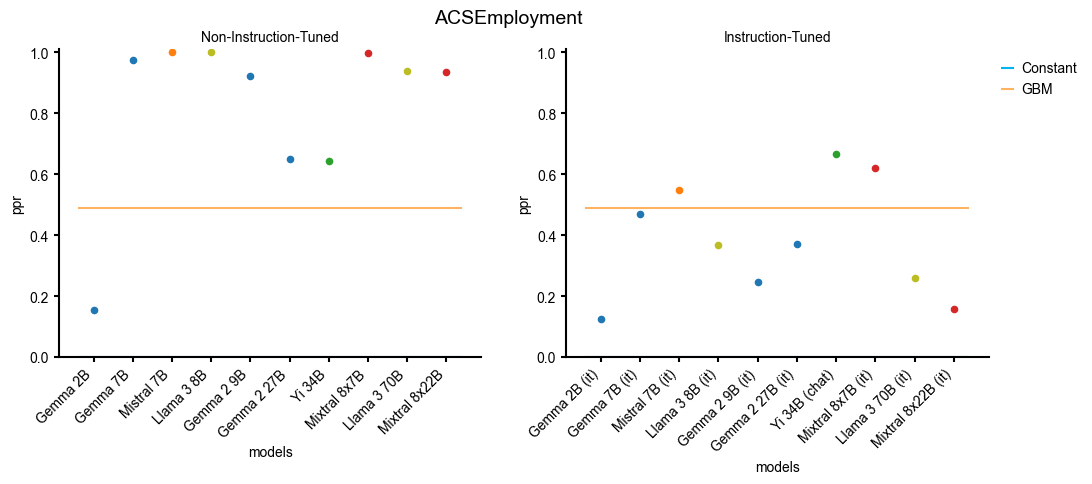

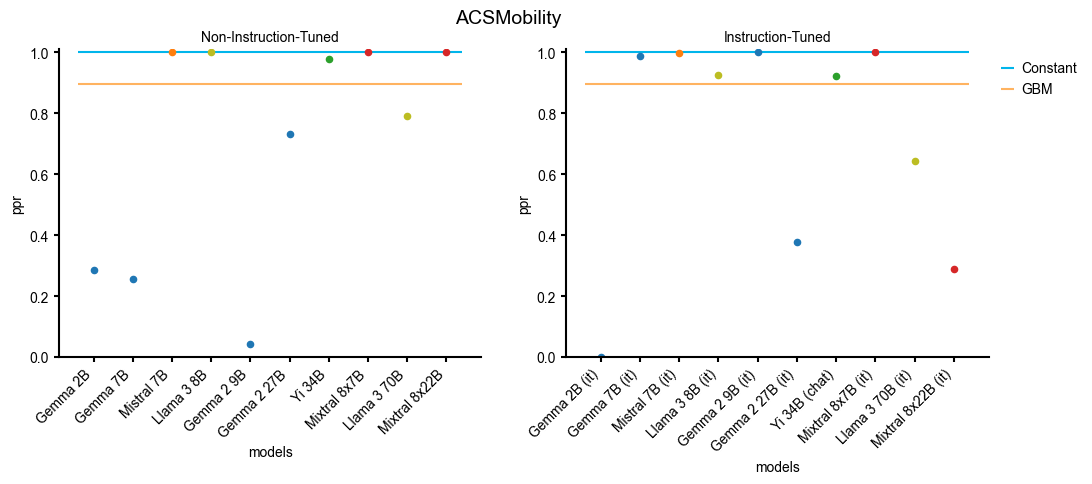

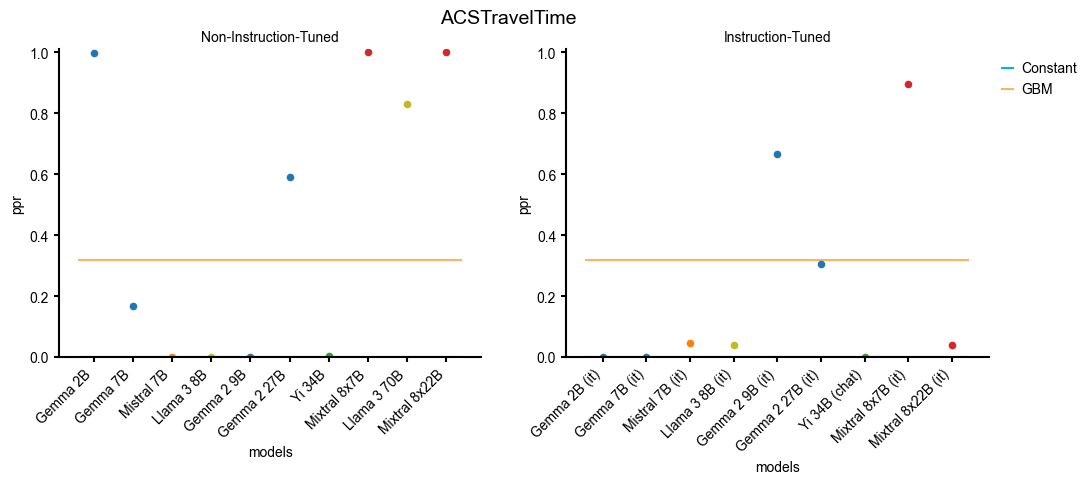

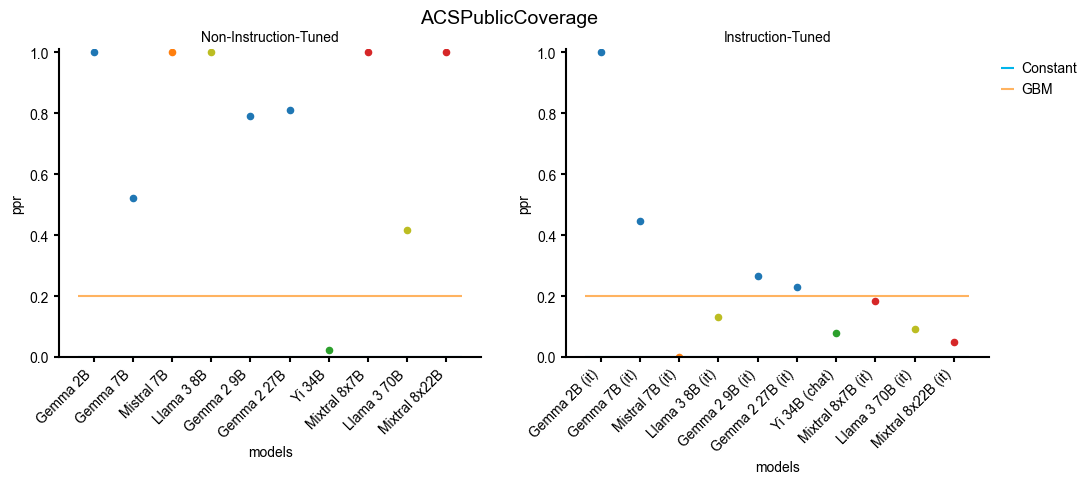

In [31]:
for task in ACS_TASKS:
    scatter_plot(task, metric="ppr")

## Towards Model Multiplicity

Can we find models with similar accuracy, but different error rates?

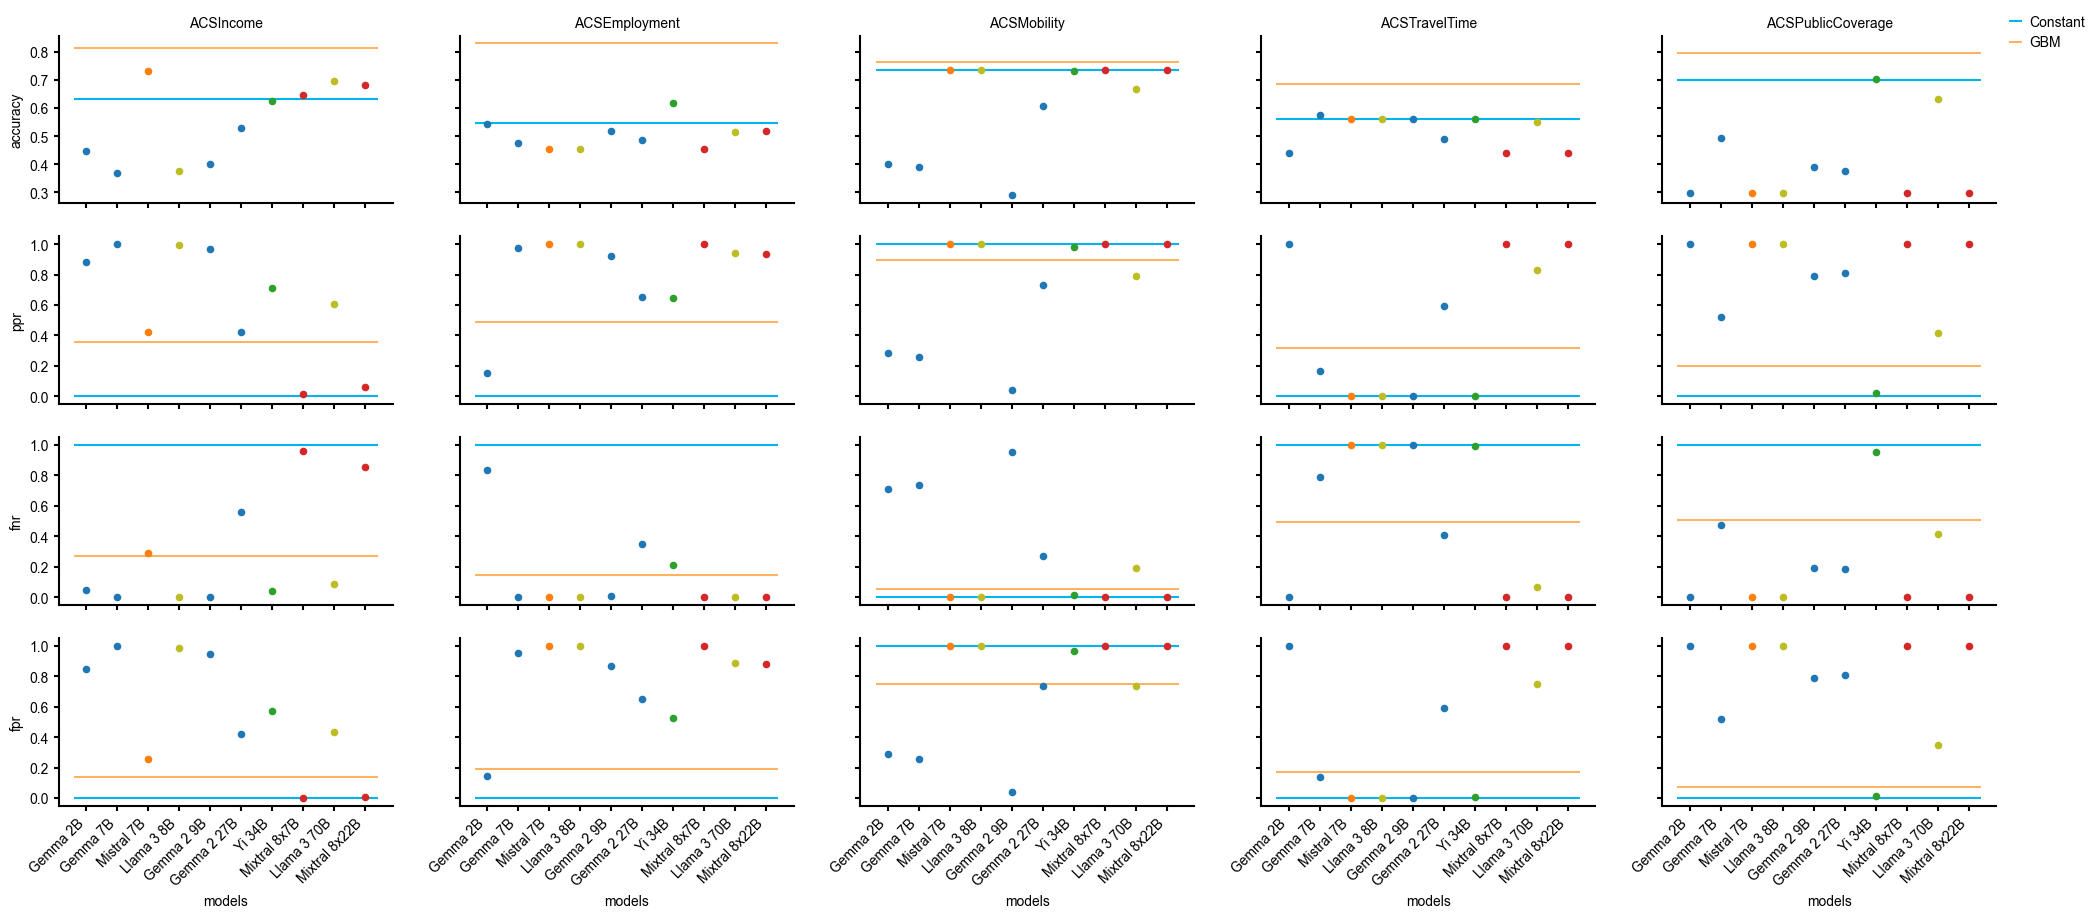

In [32]:
metrics = [
    "accuracy",
    # "accuracy_diff",
    "ppr",
    #"ppr_diff",
    "fnr",
    # "fnr_diff",
    "fpr",
    # "fpr_diff",
]
tasks = ACS_TASKS

models = get_models_for_task(task)
models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
models_instruct = [m for m in models if is_instruction_tuned(m)]
models = models_non_instruct

fig, axs = plt.subplots(
    len(metrics),
    len(tasks),
    figsize=(5 * len(tasks), 2.5 * len(metrics)),
    sharex=True,
    sharey="row",
)

for j, t in enumerate(tasks):
    axs[0, j].set_title(t)
    axs[len(metrics) - 1, j].set_xlabel("models")
    for i, m in enumerate(metrics):
        axs[i, 0].set_ylabel(m)
        axs[i, j].set_xticks(
            torch.arange(0, len(models)),
            list(map(prettify_model_name, models)),
            rotation=45,
            ha="right",
        )

        offset = 0.4
        for baseline_name, baseline_res in baseline_results_all_tasks[t].items(): 
            if baseline_name in ["Constant", "GBM"]:
                axs[i,j].hlines(baseline_res[m], xmin=-offset, xmax=len(models)-(1-offset), colors=baseline_colors[baseline_name], label=baseline_name, linestyle='-', zorder=0)


        for model_key in models:
            try:

                results = results_all_tasks[t][model_to_key(model_key, t)]
                # get correct index for model
                idx = (
                    models_non_instruct.index(model_key)
                    if not is_instruction_tuned(model_key)
                    else models_instruct.index(model_key)
                )

                axs[i, j].scatter(
                    idx,
                    results[m],
                    c=model_colors[model_key.split("/")[1].split("-")[0]],
                    s=20,
                )

                # axs[i, j].bar(
                #     idx,
                #     results_all_tasks[task][model_to_key(model, task)][m],
                #     width=0.25,
                #     color=model_colors[model.split("/")[1].split("-")[0]],
                # )
            except:
                print(
                    f"Results not availables for task '{t}' and model '{model_key}'. Skipped."
                )
legend_items = axs[0, -1].get_legend_handles_labels()
handles = legend_items[0]#+ legend_costs[0]
labels = legend_items[1] #+ legend_costs[1]

plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 4.8), handlelength=0.95, handletextpad=0.5)

plt.show()

In [33]:
results_all_tasks["ACSIncome"][
    model_to_key("mistralai/Mixtral-8x22B-v0.1", "ACSIncome")
]["accuracy"]

0.680967257434665

In [34]:
results_all_tasks["ACSIncome"][
    model_to_key("meta-llama/Meta-Llama-3-70B", "ACSIncome")
]["accuracy"]

0.6970982276960048

In [35]:
results_all_tasks["ACSIncome"][
    model_to_key("mistralai/Mixtral-8x22B-v0.1", "ACSIncome")
]["fpr"]

0.00819259245179011

In [36]:
results_all_tasks["ACSIncome"][
    model_to_key("meta-llama/Meta-Llama-3-70B", "ACSIncome")
]["fpr"]

0.4307003621087847

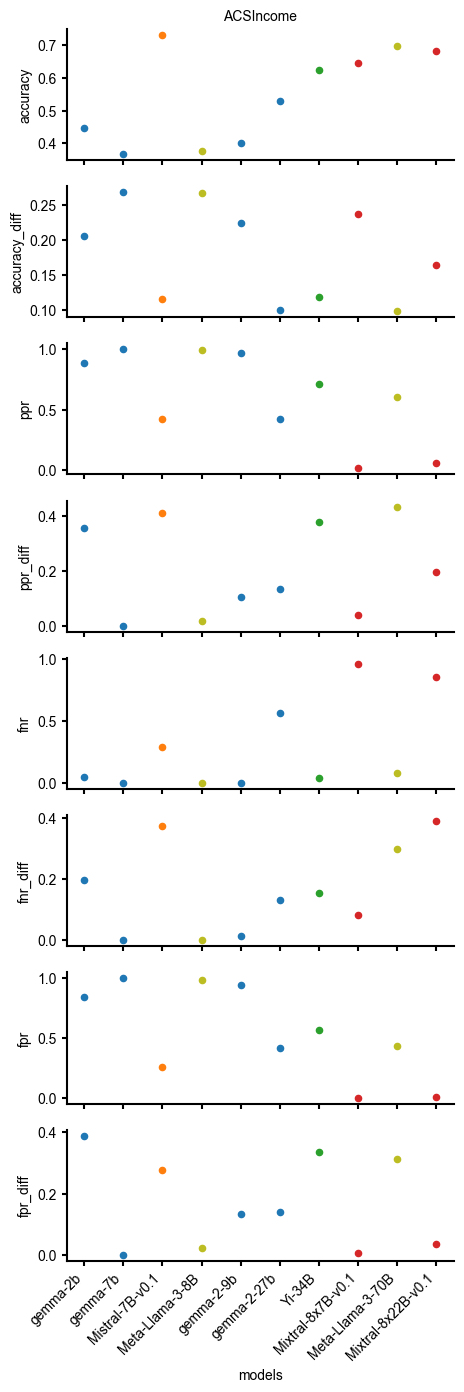

In [37]:
metrics = [
    "accuracy",
    "accuracy_diff",
    "ppr",
    "ppr_diff",
    "fnr",
    "fnr_diff",
    "fpr",
    "fpr_diff",
]
tasks = ["ACSIncome"]

models = get_models_for_task(task)
models_non_instruct = [m for m in models if not is_instruction_tuned(m)]
models_instruct = [m for m in models if is_instruction_tuned(m)]

fig, axs = plt.subplots(
    len(metrics),
    1,
    figsize=(5 * len(tasks), 2 * len(metrics)),
    sharex=True,
    sharey="row",
)

for j, t in enumerate(tasks):
    axs[0].set_title(t)
    axs[len(metrics) - 1].set_xlabel("models")
    for i, m in enumerate(metrics):
        axs[i].set_ylabel(m)
        axs[i].set_xticks(
            torch.arange(0, len(models_non_instruct)),
            list(map(model_name_only, models_non_instruct)),
            rotation=45,
            ha="right",
        )

        for model_key in models_non_instruct:
            try:

                results = results_all_tasks[t][model_to_key(model_key, t)]
                # get correct index for model
                idx = (
                    models_non_instruct.index(model_key)
                    if not is_instruction_tuned(model_key)
                    else models_instruct.index(model_key)
                )

                axs[i].scatter(
                    idx,
                    results[m],
                    c=model_colors[model_key.split("/")[1].split("-")[0]],
                    s=20,
                )

            except:
                print(
                    f"Results not availables for task '{t}' and model '{model_key}'. Skipped."
                )

plt.show()

## Agreement Rates

In [38]:
mixtral_8x22b_acc = results_all_tasks['ACSIncome'][model_to_key('mistralai/Mixtral-8x22B-v0.1', 'ACSIncome')]['accuracy']
llama3_70b_acc = results_all_tasks['ACSIncome'][model_to_key('meta-llama/Meta-Llama-3-70B', 'ACSIncome')]['accuracy']

print(f"Accuracy\n Mixtral-8x22B:\t{mixtral_8x22b_acc:0.4f}\n Llama-3-70B:\t{llama3_70b_acc:0.4f}")

Accuracy
 Mixtral-8x22B:	0.6810
 Llama-3-70B:	0.6971


In [39]:
mixtral_8x22b_scores = risk_scores_all_tasks['ACSIncome'][model_to_key('mistralai/Mixtral-8x22B-v0.1', 'ACSIncome')]
llama3_70b_scores = risk_scores_all_tasks['ACSIncome'][model_to_key('meta-llama/Meta-Llama-3-70B', 'ACSIncome')]



Agreement Rate

In [40]:
int(((mixtral_8x22b_scores > 0.5) == (llama3_70b_scores > 0.5)).sum())/len(mixtral_8x22b_scores)

0.5060498648242715

In [41]:
# Expected Agreement Rate (prob both are correct * prob both worng)
(mixtral_8x22b_acc * llama3_70b_acc) + (( 1- mixtral_8x22b_acc) *  (1 - llama3_70b_acc))

0.5713366514227582